# Recommender System for Reddit

## Contents

- Data extraction: web scraping using PushshiftAPI for Reddit
- Overview of Collaborative Filtering
- Case study: non-negative matrix factorization (NMF) 
- Implementation of NMF to make subreddit recommendations to users

## Data extraction and visualization

The PushshiftAPI allows us to easily access large amounts of data from reddit.

First, we retrieve a list of usernames from recent submissions on reddit.

In [42]:
import pandas as pd
import numpy as np
from psaw import PushshiftAPI
from sklearn.decomposition import NMF

api = PushshiftAPI()

gen = api.search_submissions(limit=3000, over_18=False)
users = set()
for post in gen:
    users.add(post.d_['author'])

print(len(users))

2258


We can then retrieve all comments from each user and count the numbers of comments by subreddit. 

In [43]:
users_subreddits = {}
for user in users:
    gen = api.search_comments(author=user, limit=50)
    comments = []
    for post in gen:
        comments.append(post.d_)  
    post_count = {}
    for com in comments:
        post_count[com['subreddit']] = post_count.get(com['subreddit'], 0) + 1 # count numbers of comments on a subreddit
    users_subreddits[user] = post_count

Convert the dictionary to a pandas dataframe and save it as a csv file for later use.

In [44]:
df = pd.DataFrame.from_dict(users_subreddits)
df.to_csv('data/users_subreddits.csv', encoding='utf-8')
print(df.shape)

(7399, 2258)


Visualizing the number of comments for each subreddits. As it is the case with most recommender systems, users mainly interact with a small proportion of the available products.

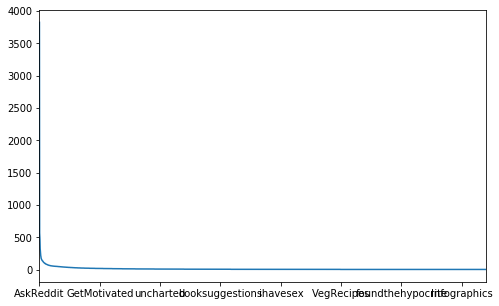

In [45]:
df.sum(axis=1).sort_values(ascending=False).plot(figsize=(8,5))

## Collaborative Filtering

A common approach for recommendation systems is collaborative filtering. This strategy is based on users' past online behaviors — e.g. previous purchases or movie ratings — and bypasses the need to create profiles and collect data extensively. The assumption is that users with similar online history tend to have common interests. Relationships between users are analysed to make new recommendations based on similar interests. The advantage of collaborative filtering is that it does not rely on domain-specific knowledge and yet is able to make accurate predictions. In addition, the use of users' past online behaviors allows retrieving complex underlying patterns that would be otherwise hidden from a search based on data attributes.

The two main approaches to collaborative filtering are neighborhood models and latent factor models. Neighborhood models aim to compute the relationships between users or between items. Latent factor models constitute an alternative approach that transform items and users to the same latent factor space inferred from patterns in the data, allowing comparisons between the two. The extracted factors may correspond to some concrete characteristics or to more abstract uninterpretable dimensions of the items. For users, the latent factors measure the affinity of a user to the corresponding product profiles. 

## Non-negative Matrix Factorization

Common matrix factorization methods used in latent factor models include singular value decomposition (SVD), probabilistic latent semantic analysis (pLSA) and non-negative matrix factorization (NMF). Non-negative matrix factorization has two main advantages over the other techniques: it solves the issue of sparcity and provides a high level of interpretability. In a real-world setting, users will only interact with a few items among a much larger catalogue. This results in a very sparse matrix where about 99\% of entries have no value. The goal is to predict these missing values given the available data. Non-negative matrix factorization is an efficient way to extract sparse and meaningful features from high-dimensional data. Additionally, NMF allows pairing recommendation systems with explanations for the recommendations. This idea is visualized in the following figure where two distinct categories of products (drinks and dairy products) have been highlighted based on customers' purchase history.

<!-- ![nmf.PNG](attachment:nmf.PNG) -->
<img src="nmf.PNG" width="800" />

$R$ is the initial matrix with products as columns and customers as rows, each value representing the number of purchases. $R$ is decomposed into two smaller matrices $U$ and $V$, whose dimensions are determined by the number of components, and can be approximately reconstructed by the dot product of $U$ and $V^T$.

The choice for the number of latent factors depends on the situation. Increasing the number of latent factors will reveal more hidden features from the data which improves the quality of the recommendation system. However, too high of an increase can overfit the data, thereby reducing the recommendation quality.

Predicting missing entries for the initial matrix $R$ can be computed as follows: Where $U$ contains the users' latent factors and $V$ the items' latent factors, the task is to find two matrices $U$ and $V$ with dimensions $u,k$ and $d, k$ such that their product is $\hat{R}$ which approximates $R$ and where all entries are filled.

\begin{equation}
R \approx U \times V^T = \hat{R}
\end{equation}

In order to predict the rating of an item  $j$ by user $i$, the dot product of the row $i$ from matrix $U$ and column $j$ from matrix $V$ should be calculated as follows:

\begin{equation}
\hat{r}_{ij} = u_i v_j^T = \sum_{k=1}^{K} u_{ik}v_{kj}
\end{equation}

We showed that by having $U$ and $V$, we can approximate the initial matrix $R$ with the estimated values for the missing inputs. Now, the question that arises is how to obtain the $U$ and $V$ matrices. One of the well-known optimization algorithms which can be used here is gradient descent. In this algorithm, $U$ and $V$ are initialized with random values. Then at each iteration the product of $U$ and $V$ is calculated and compared to the initial matrix $R$. If their product is close to $R$, we stop the iteration, otherwise the values of $U$ and $V$ are updated in a way as to minimize this difference. This procedure continues until we reach a local minimum of estimated error between the approximated and the real matrices. 

The squared error for each user-item pair can be calculated by the following equation: 

\begin{equation}
e_{ij}^2 = (r_{ij} - \hat{r}_{ij})^2 = (r_{ij} - \sum_{k=1}^{K} u_{ik}v_{kj})^2
\end{equation}

$u_{ik}$ and $v_{kj}$ should be updated to minimize the error. To do that, we need to differentiate the above error equation based on these two variables separately:

\begin{equation}
\frac{\partial e_{ij}^2}{ \partial u_{ik}} = -2(r_{ij} - \hat{r}_{ij})(u_{kj}) = -2e_{ij}u_{kj}
\end{equation}

\begin{equation}
\frac{\partial e_{ij}^2}{ \partial v_{kj}} = -2(r_{ij} - \hat{r}_{ij})(v_{ik}) = -2e_{ij}v_{ik}
\end{equation}

By obtaining the gradient, we can update the values of $u_{ik}$ and $v_{kj}$ in the direction of minimizing the error:

\begin{equation}
\acute{u_{ik}} = u_{ik} + \alpha \frac{\partial e_{ij}^2}{ \partial u_{ik}} = u_{ik} + 2\alpha e_{ij}u_{kj}
\end{equation}

\begin{equation}
\acute{v_{kj}} = v_{kj} + \alpha \frac{\partial e_{ij}^2}{ \partial v_{kj}} = v_{kj} + 2\alpha e_{ij}v_{ik}
\end{equation}

Here, $\alpha$ represents the learning rate and determines the rate of approaching the minimum. $\alpha$ should be chosen carefully. Too high of a learning rate will take large steps towards the minimum and might not converge towards it, eventually fluctuating around it. On the other hand, too low of a learning rate will either take too long to converge or get stuck in an undesirable local minimum.

Using the above update rules, we can then repeat the operation until the overall error is minimized and specify when to stop the process. To summarize, the missing entries of the original matrix can be approximated by the simple product of $U$ and $V$, which are calculated through this optimization process.

One important thing to consider in the above scenario is that the matrices $U$ and $V$ are non-negative, hence this method is called non-negative factorization.

## NMF implementation

We will use the NMF class implemented in scikit-learn along with the data we extracted previously to make subreddits recommendations to users. 

In [54]:
df = pd.read_csv('data/users_subreddits.csv')
df = df.rename({'Unnamed: 0': 'subreddit'}, axis=1).set_index('subreddit')
df1 = df[df.sum(axis=1) > 10] # considering subreddits with more than 10 comments and replacing NaN values with 0s
df1 = df1.fillna(0)
df1

,jaycebodierafaelkody,idieverynightfor8hrs,hsebastian67,Tk_Octo,Anti6,Nuttennut,dahnana,Literal_Aids,kefyras,Gabbaman,...,PriestOfTodd,cosomos1,CbSeal,berrybrain43,reuben88620,vayderr,ibrala,D4rkW4rr1or,UnknownBoi0,jsoft2
subreddit,,,,,,,,,,,,,,,,,,,,,
me_irl,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
memes,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
funny,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aww,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WTF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sandboxtest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pokemongiveaway,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aviationmaintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
nmf = NMF(n_components=6)
nmf.fit(df1)

U = pd.DataFrame(np.round(nmf.components_,2), columns=df1.columns)

V = pd.DataFrame(np.round(nmf.transform(df1),2), columns=U.index)
V.index = df1.index

reconstructed = pd.DataFrame(np.round(np.dot(V,U),2), columns=df1.columns)
reconstructed.index = df1.index
reconstructed

,jaycebodierafaelkody,idieverynightfor8hrs,hsebastian67,Tk_Octo,Anti6,Nuttennut,dahnana,Literal_Aids,kefyras,Gabbaman,...,PriestOfTodd,cosomos1,CbSeal,berrybrain43,reuben88620,vayderr,ibrala,D4rkW4rr1or,UnknownBoi0,jsoft2
subreddit,,,,,,,,,,,,,,,,,,,,,
me_irl,0.20,0.0,0.0,0.0,0.0,0.0,0.00,0.03,0.00,0.03,...,0.0,0.0,0.00,0.03,0.0,0.0,0.0,0.0,0.09,0.0
memes,7.06,0.0,0.0,0.0,0.0,0.0,0.12,0.82,0.00,1.06,...,0.0,0.0,0.12,0.00,0.0,0.0,0.0,0.0,2.82,0.0
funny,0.18,0.0,0.0,0.0,0.0,0.0,0.01,0.03,0.01,0.06,...,0.0,0.0,0.00,0.21,0.0,0.0,0.0,0.0,0.08,0.0
aww,0.13,0.0,0.0,0.0,0.0,0.0,0.01,0.03,0.01,0.06,...,0.0,0.0,0.00,0.28,0.0,0.0,0.0,0.0,0.05,0.0
WTF,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.01,...,0.0,0.0,0.00,0.04,0.0,0.0,0.0,0.0,0.02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sandboxtest,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0
Pokemongiveaway,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0
aviationmaintenance,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0


Using this reconstructed matrix, new recommendations can be made to users for items they are likely to enjoy. We simply have to select the highest values that were previously empty for a user and recommend these subreddits to her. The latent factors allow us to pair these recommendations with an explanation of the type "Since you liked subreddits x, we selected these subreddits for you".

In [35]:
df1['UnknownBoi0'].nlargest(5)

subreddit
PewdiepieSubmissions    14.0
softwaregore             9.0
dankmemes                3.0
CrappyDesign             3.0
memes                    1.0
Name: UnknownBoi0, dtype: float64

In [36]:
reconstructed['UnknownBoi0'].nlargest(5)

subreddit
memes                   2.82
teenagers               1.86
dankmemes               0.57
PewdiepieSubmissions    0.51
AskOuija                0.20
Name: UnknownBoi0, dtype: float64

In the previous example, user '*UnknownBoi0*' commented, among others, in the subreddits '*PewdiepieSubmissions*' and '*dankmemes*'. Using the reconstructed matrix, we can recommend the subreddits '*memes*' and '*teenagers*' to this user, which seem like sound recommendations since these subreddits all have related content.

## Conclusion

Recommendation systems is a broad field that encompasses many different methods. Among them is the collaborative filtering technique which aims at finding relations between users or between items. Matrix factorization is used in latent factors models and can reveal hidden features in the data. We closely examined non-negative matrix factorization, a method that solves the issue of sparcity and provides a high level of interpretability. 
As we have seen, approximating the initial user-item matrix is a simple regularization problem common to many machine learning techniques. Nowadays, linear factor models have been replaced by deeper models, a topic which could provide for further consideration. 